# Tumor Detection with RPN and FPR Models

## Step 1: Load the FPR Model

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import cv2

with open('./Brainhack/final_project/data_test.pkl', 'rb') as f:
   Data = pickle.load(f)
    
bbox_list1 = Data['GT']
u = Data['annotaton']

image_data1 = np.transpose(Data['images'], (0, 3, 1, 2))
images = torch.tensor(image_data1)
images = images.to(dtype=torch.float32)

In [2]:
def Get_RoI(RPN, image_data, bbox_list1, anchor_list, u, th2):
    # Initialize a list to store predicted RoIs
    predict_roi = []

    # Loop over each image in the batch
    for i in range(image_data.shape[0]):
        img = image_data[i:i+1,:,:,:]
        img = img.to(device)
        
        # Predict anchor deltas and objectness scores
        anchor_deltas, objectiveness_score = model(img)
        anchor_deltas = anchor_deltas.detach().numpy()
        objectiveness_score = objectiveness_score.detach().numpy()
        objectiveness_score = objectiveness_score.reshape(-1, n_anchors)
        anchor_deltas = anchor_deltas.reshape(-1, n_anchors, 4)

        # Extract deltas for adjustment
        dx, dy, dw, dh = anchor_deltas[:, :, 0], anchor_deltas[:, :, 1], anchor_deltas[:, :, 2], anchor_deltas[:, :, 3]

        # Convert anchor box coordinates to center format
        anchor_width, anchor_height, anchor_center_x, anchor_center_y = to_center_format(
            anchor_list[:, 0], anchor_list[:, 1], anchor_list[:, 2], anchor_list[:, 3])

        # Adjust the anchors using the predicted deltas to obtain the final RoIs
        roi_width, roi_height, roi_center_x, roi_center_y = adjust_deltas(
            anchor_width, anchor_height, anchor_center_x, anchor_center_y, dx, dy, dw, dh)

        # Convert RoIs back to VOC format
        roi_min_x, roi_min_y, roi_max_x, roi_max_y = to_VOC_format(roi_width, roi_height, roi_center_x, roi_center_y)
        roi = np.vstack((roi_min_x, roi_min_y, roi_max_x, roi_max_y)).T

        # Filter out small and big RoIs based on size thresholds
        min_size = 30
        max_size = 160
        width = roi[:, 2] - roi[:, 0]
        height = roi[:, 3] - roi[:, 1]
        keep = np.where((width >= min_size) & (height <= max_size) & (height >= min_size))[0]
        roi = roi[keep]
        score = objectiveness_score[:, keep]

        # Sort RoIs by objectiveness score
        sorted_idx = score.flatten().argsort()[::-1]
        roi_sorted = roi[sorted_idx]
        bbox_list = bbox_list1[i]

        # Final filtering based on region content
        imgg = np.reshape(img,(512,512,3))
        img1 = imgg[:,:,1]
        indd = []
        for ii in range(len(roi_sorted)):
            bbox_list11 = roi_sorted[ii]
            anchor_width1, anchor_height1, anchor_center_x1, anchor_center_y1 = to_center_format(
                bbox_list11[0], bbox_list11[1], bbox_list11[2], bbox_list11[3])

            img2 = img1[np.int64(anchor_center_x1-anchor_width1/2):np.int64(anchor_center_x1+anchor_height1/2),
                        np.int64(anchor_center_y1-anchor_width1/2):np.int64(anchor_center_y1+anchor_height1/2)]

            if (img2.shape[0]) > 0:
                indd.append(ii)
                if len(indd) >= th2:
                    break

        roi_sorted = roi_sorted[indd, :]
        predict_roi.append(roi_sorted)
      
    return predict_roi

def IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2
    """

    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])

    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0

    # ------computing union------
    # sum of area of both the boxes - area_overlap

    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])

    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])

    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2

    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2

    # union
    area_union = area_union_overlap - area_overlap

    # compute IOU
    iou = area_overlap/ area_union

    return iou


def to_VOC_format(width, height, center_x, center_y):
    """
    Convert center coordinates format to VOC format (min-max coordinates)
    
    Parameters:
    - width (float): The width of the bounding box
    - height (float): The height of the bounding box
    - center_x (float): The x-coordinate of the center of the bounding box
    - center_y (float): The y-coordinate of the center of the bounding box
    
    Returns:
    - x_min (float): The minimum x-coordinate of the bounding box
    - y_min (float): The minimum y-coordinate of the bounding box
    - x_max (float): The maximum x-coordinate of the bounding box
    - y_max (float): The maximum y-coordinate of the bounding box
    """
    x_min = center_x - 0.5 * width
    y_min = center_y - 0.5 * height
    x_max = center_x + 0.5 * width
    y_max = center_y + 0.5 * height
    return x_min, y_min, x_max, y_max

def to_center_format(xmin_list, ymin_list, xmax_list, ymax_list):
    """
    Convert bounding box coordinates from (xmin, ymin, xmax, ymax) format to
    (x_center, y_center, width, height) format.
    """
    height = ymax_list - ymin_list
    width = xmax_list - xmin_list
    
    center_x = xmin_list + 0.5 * width
    center_y = ymin_list + 0.5 * height
    
    return width, height, center_x, center_y

def adjust_deltas(anchor_width, anchor_height, anchor_center_x, anchor_center_y, dx, dy, dw, dh):
    """
    Adjust the anchor box with predicted offset
    """
    # ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    center_x = dx * anchor_width + anchor_center_x

    # ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    center_y = dy *  anchor_height + anchor_center_y

    # w = np.exp(dw) * anc_width[:, np.newaxis]
    width = np.exp(dw) * anchor_width

    # np.exp(dh) * anc_height[:, np.newaxis]
    height = np.exp(dh) * anchor_height

    return width, height, center_x, center_y

# Function to evaluate precision, recall, and F1-score for a single ground truth bbox and predicted RoIs
def evaluate(bbox_list, roi_sorted, th1):
    tp, fp, fn = 0, 0, 0  # Initialize True Positive, False Positive, False Negative counts
    th2,_ = roi_sorted.shape
    for k1 in range(th2):
        iou1 = IOU(bbox_list, roi_sorted[k1])  # Calculate IoU between ground truth bbox and predicted RoI
        if (iou1 > th1):
            tp += 1  # Increment TP if IoU exceeds threshold
    if tp == 0:
        fn += 1  # Increment FN if no TP found

    fp = th2 - tp  # Calculate FP as the difference between total predictions and TP
    if (tp+fp) > 0:
        per = tp / (tp + fp)  # Calculate precision
    else:
        per = 0
    if (tp+fn) > 0:
        rec = tp / (tp + fn)  # Calculate recall
    else:
        rec = 0
    if (per + rec) > 0:
        f1_score = (2 * per * rec) / (per + rec)  # Calculate F1-score
    else:
        f1_score = 0
    return per, rec, f1_score, fp

def FPR_roi_torch(model,roi,image_data1,th2):
    proposed_roi = []
    for i in range(len(roi)):
        img3 = np.zeros((th2,60,60))
        img = image_data1[i,:,:,:]
        img = img[:,:,1]
        for k1 in range(th2):
            bbox0 = roi[i][k1]
            dia1 = bbox0[2]-bbox0[0]
            dia2 = bbox0[3]-bbox0[1]
            dia_min = min([dia1,dia2])
            dia_max = max([dia1,dia2])
            #if (dia_min>10)  & (dia_max<120):
            
            img2 = img[np.int64(bbox0[0]):np.int64(bbox0[2]),np.int64(bbox0[1]):np.int64(bbox0[3])]

            # Crop the region of interest
            img2 = img[int(bbox0[0]):int(bbox0[2]), int(bbox0[1]):int(bbox0[3])]
        
            if img2.size == 0:
                continue  # Skip empty crops

        # Convert to tensor and add batch and channel dims
            img2_tensor = torch.tensor(img2, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, H, W)

        # Resize using bicubic interpolation
            img3[k1,:,:] = F.interpolate(img2_tensor, size=(60, 60), mode='bicubic', align_corners=False)
            
            #img3[k1,:,:] = cv2.resize(img2, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
            
        image_data2 = img3.reshape(-1, 1, 60, 60).astype('float32') / 255
        new_data = torch.tensor(image_data2).float()
        with torch.no_grad():  # No need to track gradients during evaluation
            outputs = model(new_data)
            _, predicted = torch.max(outputs, 1)
        t1 = predicted.numpy()
        ind = np.where(t1==1)
        for j in ind:
            proposed_roi.append(roi[i][j])
    return proposed_roi

# Set stride and image dimensions
stride = 8
#w = h = 800 # Assuming square images with 800x800 pixels

# Calculate anchor centers at every stride interval
x_center = np.arange(3, 512, stride) # X-coordinates for anchor centers
y_center = np.arange(3, 512, stride) # Y-coordinates for anchor centers
        
# Generate all ordered pairs of x and y centers
center_list = np.array(np.meshgrid(x_center, y_center,  sparse=False, indexing='xy')).T.reshape(-1,2)
    ##########################################################    
# Define anchor box sizes (width, height)       
anchor_shape = [(8,8),(25,25),(38,38),(58,58),(85,85),(120,120)]
n_anchors = len(center_list) * len(anchor_shape) # Total number of anchors
        
# Initialize an array to store anchor boxes
anchor_list = np.zeros(shape= (n_anchors, 4))

# Generate anchor boxes for each center and each anchor size      
count = 0
for center in center_list:
         center_x, center_y = center[0], center[1]
         # Create anchors for each shape
         for w,h in anchor_shape:
             anchor_xmin,anchor_ymin,anchor_xmax,anchor_ymax = to_VOC_format(w, h, center_x, center_y)
             # Store the anchor coordinates
             anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
             count += 1

## Step 2: Load the FPR Model

In [4]:
# Define your model architecture (same as the one used during training)
class TumorCNN(nn.Module):
    def __init__(self):
        super(TumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 15 * 15, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = self.pool(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.ReLU()(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 15 * 15)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

# Load the trained model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = TumorCNN()
# Load the saved model weights

state_dict = torch.load("./BrainHack/final_project/FPR_Tumor.pth", map_location='cpu', weights_only=True)
model1.load_state_dict(state_dict)

model1.eval()  # Set the model to evaluation mode

TumorCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=14400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

## Step 3: Load the RPN Model

In [10]:


# Define the CustomRPN class inheriting from nn.Module
class CustomRPN(nn.Module):
    def __init__(self, k=6, weight_decay=0.000001):
        super(CustomRPN, self).__init__()

        # Define the first set of convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer for downsampling

        # Define the second set of convolutional layers
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        # Continue adding more convolutional layers for deeper feature extraction
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
        # Define additional convolutional layers
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
        # Define a transposed convolutional layer for upsampling
        self.deconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=1, stride=2, padding=1, output_padding=1)

        # Define final convolutional layers for bounding box regression and classification
        self.conv15 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, padding=1)
        self.conv16 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)
        self.conv17 = nn.Conv2d(in_channels=512, out_channels=510, kernel_size=1)

        # Regressor for bounding box prediction and classifier for objectness score
        self.regressor = nn.Conv2d(in_channels=512, out_channels=4*k, kernel_size=1)
        self.classifier = nn.Conv2d(in_channels=512, out_channels=k, kernel_size=1)

    # Forward pass through the network
    def forward(self, x):
        x1 = F.relu(self.conv1(x))  # First convolutional block
        x2 = F.relu(self.conv2(x1))
        p1 = self.pool(x2)
        
        x3 = F.relu(self.conv3(p1))  # Second convolutional block
        x4 = F.relu(self.conv4(x3))
        p2 = self.pool(x4)
        
        x5 = F.relu(self.conv5(p2))  # Third convolutional block
        x6 = F.relu(self.conv6(x5))
        x7 = F.relu(self.conv7(x6))
        p3 = self.pool(x7)
        
        x8 = F.relu(self.conv8(p3))  # Fourth convolutional block
        x9 = F.relu(self.conv9(x8))
        x10 = F.relu(self.conv10(x9))
        p4 = self.pool(x10)
        
        x11 = F.relu(self.conv11(p4))  # Fifth convolutional block
        x12 = F.relu(self.conv12(x11))
        x13 = F.relu(self.conv13(x12))
        
        x14 = self.deconv1(x13)  # Upsampling with transposed convolution
        x15 = self.conv15(x14)

        # Additional convolutions for feature maps at different stages
        x18 = self.conv16(p3)
        x19 = self.conv17(x10)
        
        # Concatenate feature maps from different layers
        concatenated = torch.cat([x15, x19, x18], dim=1)
        
        # Predict bounding boxes (regressor) and objectness score (classifier)
        regressor = self.regressor(concatenated)
        classifier = torch.sigmoid(self.classifier(concatenated))

        return regressor, classifier

# Load the entire model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomRPN()
# Load the saved model weights

state_dict = torch.load("./BrainHack/final_project/RPN_torch_weights.pth", map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

model.eval()  # Set the model to evaluation mode


CustomRPN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_siz

## Step 4: Visualize Predictions and Ground Truth after RPN and FPR model

/tmp/ipykernel_22070/3643551809.py:223: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img3[k1,:,:] = F.interpolate(img2_tensor, size=(60, 60), mode='bicubic', align_corners=False)


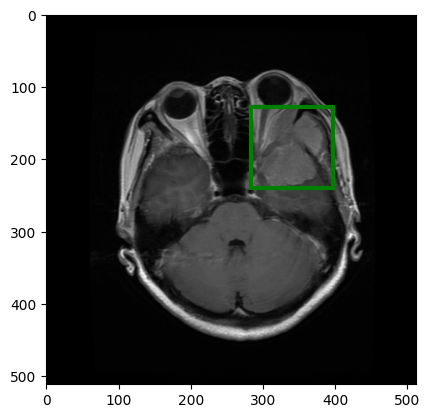

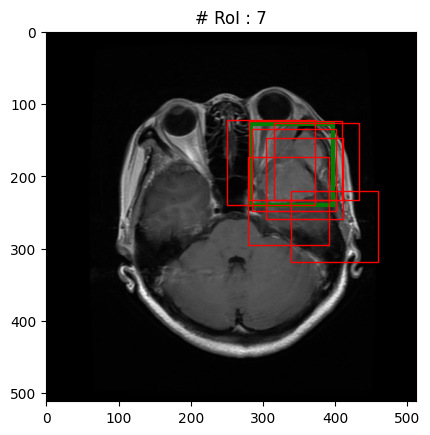

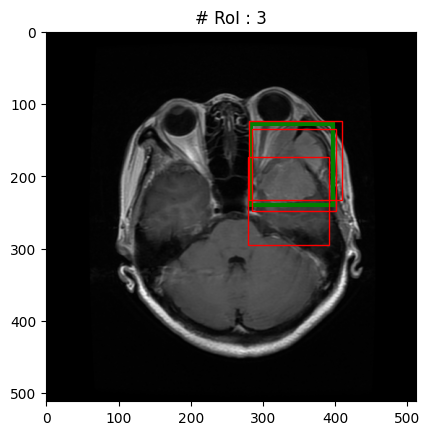

In [56]:

# Prompt the user to input the CT image number, IoU threshold, and number of predicted bounding boxes
num = 33#eval(input('Input the number of CT image:'))
th2 = 7#eval(input('Input the number of predicted bounding box:'))


# Prompt the user to input the CT image number, IoU threshold, and number of predicted bounding boxes
#num = eval(input('Input the number of CT image:'))
#th2 = eval(input('Input the number of predicted bounding box:'))

# Extract the selected CT image and the corresponding ground truth bounding boxes
image_data2 = images[num:num+1,:,:,:]
bbox_list2 = bbox_list1[num:num+1,:]
GT = bbox_list2[0]  # Ground truth bounding box


# Get the Regions of Interest (RoIs) using the pre-trained RPN model
roi = Get_RoI(model, image_data2, bbox_list2, anchor_list, u, th2)
proposed_roi = FPR_roi_torch(model1,roi,Data['images'][num:num+1,:,:,:],th2)


imag = Data['images'][num:num+1,:,:,:]
img = np.reshape(imag, (512, 512, 3))  # Reshape image data for display

# Initialize a plot
fig, ax = plt.subplots()
plt.imshow(img[:,:,1], cmap='gray')  # Display the CT image in grayscale
# Draw the ground truth bounding box in green
rect = patches.Rectangle((GT[1], GT[0]), GT[2]-GT[0], GT[3]-GT[1], linewidth=3, edgecolor='g', facecolor='none')
ax.add_patch(rect)

# Initialize a plot
fig, ax = plt.subplots()
plt.imshow(img[:,:,1], cmap='gray')  # Display the CT image in grayscale

# Draw the ground truth bounding box in green
rect = patches.Rectangle((GT[1], GT[0]), GT[2]-GT[0], GT[3]-GT[1], linewidth=3, edgecolor='g', facecolor='none')
ax.add_patch(rect)

# Draw the predicted bounding boxes in red
for k in range(th2):
    PT = roi[0][k] 
    rect = patches.Rectangle((PT[1], PT[0]), PT[2]-PT[0], PT[3]-PT[1], linewidth=1, edgecolor='r', facecolor='none')
    plt.title('# RoI : %d' % th2)
    ax.add_patch(rect)

# Display the plot
plt.show()

per, rec, f1_score, fp = evaluate(GT, roi[0], 0.1)
#print(per, rec, f1_score)

fig, ax = plt.subplots()
plt.imshow(img[:,:,1], cmap='gray')  # Display the CT image in grayscale

# Draw the ground truth bounding box in green
rect = patches.Rectangle((GT[1], GT[0]), GT[2]-GT[0], GT[3]-GT[1], linewidth=3, edgecolor='g', facecolor='none')
ax.add_patch(rect)

# Draw the predicted bounding boxes in red
for k in range(len(proposed_roi[0])):
    PT = proposed_roi[0][k] 
    rect = patches.Rectangle((PT[1], PT[0]), PT[2]-PT[0], PT[3]-PT[1], linewidth=1, edgecolor='r', facecolor='none')
    plt.title('# RoI : %d' % len(proposed_roi[0]))
    ax.add_patch(rect)



## Step 5: Evaluate Metrics (Precision, Recall, F1)

In [8]:
# Function to evaluate precision, recall, and F1-score across multiple images
def eval_all(image_data_train, bbox_list_train,roi, th1, th2):
    
    proposed_roi = FPR_roi_torch(model1,roi,image_data_train,th2)
    
    precision, recall, f1_score, FP = [], [], [], []  # Initialize lists to store metrics
    number, _, _, _ = image_data_train.shape  # Get the number of images
    for i in range(number):
        bbox_list = bbox_list_train[i, :]  # Ground truth bbox for current image
        roi_sorted = proposed_roi[i]  # Predicted RoIs for current image
        pre, rec , f1, fp= evaluate(bbox_list, roi_sorted, th1)  # Evaluate metrics
        precision.append(pre)  # Store precision
        recall.append(rec)  # Store recall
        f1_score.append(f1)  # Store F1-score
        FP.append(fp)

    # Calculate average precision, recall, and F1-score across all images
    precision1 = (sum(precision) / number) * 100
    recall1 = (sum(recall) / number) * 100
    f1_score1 = (sum(f1_score) / number) * 100
    FP_s = (sum(FP) / number)
    return precision1, recall1, f1_score1, FP_s


# Testing dataset (subset of the original data)
image_data_test = images[:, :, :, :]
bbox_list_test = bbox_list1[:, :]


image_data_test1 = Data['images'][:, :, :, :]


th2 = 100  # Constant number of predicted bounding boxes
IoU_th = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]  # Varying IoU thresholds
pre_all_2, rec_all_2, f1_all_2 = [], [], []
# Evaluate metrics by varying IoU thresholds
for th1 in IoU_th:
    print(th1)
    roi = Get_RoI(model, image_data_test, bbox_list_test, anchor_list, u, th2)  # Get RoIs from RPN
    precision1, recall1, f1_score1, FP = eval_all(image_data_test1, bbox_list_test, roi, th1, th2)
    pre_all_2.append(precision1)
    rec_all_2.append(recall1)
    f1_all_2.append(f1_score1)

print(pre_all_2)
print(rec_all_2)
print(f1_all_2)



sensitivity = []
FP_scan = []
th1 = 0.4
for i in [1,2,4,7,17,32,70]:
    roi = Get_RoI(model, image_data_test, bbox_list_test, anchor_list, u, i)  # Get RoIs from RPN
    precision1, recall1, f1_score1, FP_s = eval_all(image_data_test1, bbox_list_test, roi, th1, i)
    sensitivity.append(recall1)
    FP_scan.append(FP_s)
    print(FP_scan)

print(FP_scan)
print(sensitivity)


0.5


/tmp/ipykernel_19039/3643551809.py:223: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img3[k1,:,:] = F.interpolate(img2_tensor, size=(60, 60), mode='bicubic', align_corners=False)


0.6
0.7
0.8
0.9
0.95
[62.949705502462685, 45.87183444496779, 26.395323427916605, 9.185849023064076, 1.0825740829023065, 0.06869578134284017]
[94.0, 92.0, 90.0, 80.0, 41.0, 5.0]
[73.30334382113645, 58.4143879656525, 38.30104108582497, 15.650398675116126, 2.0713685869193323, 0.13543040216268365]
[0.08]
[0.08, 0.2]
[0.08, 0.2, 0.4]
[0.08, 0.2, 0.4, 0.84]
[0.08, 0.2, 0.4, 0.84, 2.03]
[0.08, 0.2, 0.4, 0.84, 2.03, 3.88]
[0.08, 0.2, 0.4, 0.84, 2.03, 3.88, 8.1]
[0.08, 0.2, 0.4, 0.84, 2.03, 3.88, 8.1]
[49.0, 59.0, 82.0, 87.0, 91.0, 94.0, 97.0]


## Step 6: Plot Precision, Recall, F1 vs IoU

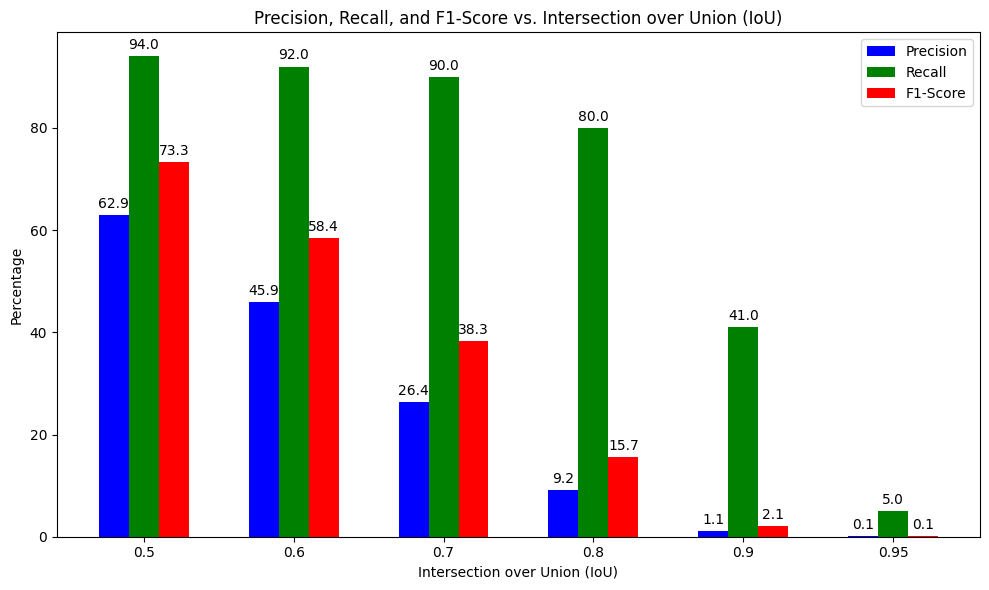

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data

th1 = IoU_th
IoUs = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
precision = pre_all_2
recall = rec_all_2
f1_score = f1_all_2

x = np.arange(len(IoUs))  # the label locations
width = 0.2  # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart
rects1 = ax1.bar(x - width, precision, width, label='Precision', color='blue')
rects2 = ax1.bar(x, recall, width, label='Recall', color='green')
rects3 = ax1.bar(x + width, f1_score, width, label='F1-Score', color='red')


# Add some text for labels, title, and custom x-axis tick labels
ax1.set_xlabel('Intersection over Union (IoU)')
ax1.set_ylabel('Percentage')
ax1.set_title('Precision, Recall, and F1-Score vs. Intersection over Union (IoU)')
ax1.set_xticks(x)
ax1.set_xticklabels(IoUs)
ax1.legend()

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.1f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()

plt.show()


## Step 7: Plot FROC Curve

/tmp/ipykernel_19039/878000509.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['0','0.125', '0.25', '0.5', '1', '2', '4', '8'])


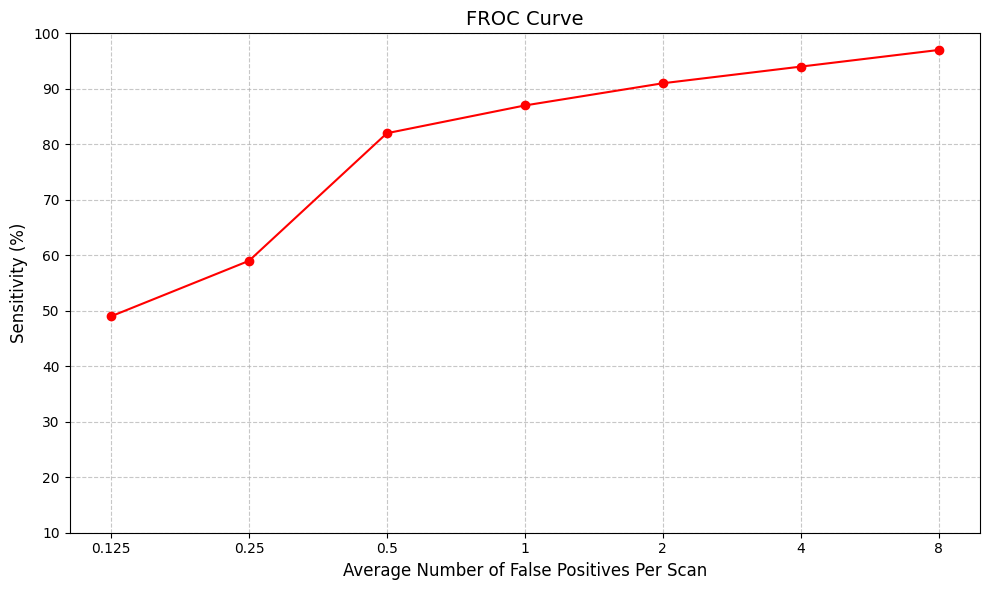

In [10]:
import matplotlib.pyplot as plt

# Data for the plot
false_positives = list(range(1,8))  # False positives per scan
sensitivity = sensitivity  # Sensitivity (in percentage)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.plot(false_positives, sensitivity, marker='o', linestyle='-', color='r')

# Set the title and labels
ax.set_title('FROC Curve', fontsize=14)
ax.set_xlabel('Average Number of False Positives Per Scan', fontsize=12)
ax.set_ylabel('Sensitivity (%)', fontsize=12)

# Set x-tick labels
#ax.set_xticks([0.125, 0.25, 0.5, 1, 2, 4, 8])
ax.set_xticklabels(['0','0.125', '0.25', '0.5', '1', '2', '4', '8'])

# Set gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Set limits for better visualization
#ax.set_xlim(0.125, 8.5)
ax.set_ylim(10, 100)

# Show the plot
plt.tight_layout()
plt.show()
